In [1]:
import h5py
import os
import numpy as np
import k3d

In [2]:
#CT_raw=['Chamf_1mm.h5', 'Cube3_1mm.h5','Cube8_1mm.h5', 'Hori_Bar_1mm.h5']
CT_raw=['Chamf_2mm.h5']
#
metric_file=os.path.normpath("METRICS_ONLY_2mm.h5")

In [3]:
CT_file=os.path.normpath(CT_raw[0])
with h5py.File(CT_file, 'r') as f:
    porosity=np.array(f.get('pores'), dtype='float64')
    mask=np.array(f.get('mask'), dtype='uint8')
    print(porosity.shape)
    print(mask.shape)
    
with h5py.File(metric_file, 'r') as f:
    keys=f.keys()
    #print(keys)
    print(f['mse-Spot area (um2)'].shape)
    test_met=np.array(f.get('mse-Spot area (um2)'), dtype='float64')

(20, 7, 6)
(20, 7, 6)
(20, 27, 27)


### Always flip axis 1 because k3d plots axis 1 inverse to matplotlib

In [30]:
def CT_registration(vol):
    mask2=vol[:,1:-1,:]
    mask2=np.flip(mask2, axis=1)
    mask2=np.flip(mask2, axis=0)
    
    return mask2

In [31]:
def MET_registration(vol):
    met2=vol[:,7:12,6:12]
    met2=np.flip(met2, axis=1)
    
    return met2

In [32]:
## Figure out where to crop the metric data and check the alignment/ consistency of the data
#met2=np.flip(test_met, axis=1)
met2=MET_registration(test_met)

mask2=CT_registration(mask)

    
plot = k3d.plot()
obj = k3d.factory.volume(mask2, scaling=[mask2.shape[2], mask2.shape[1], mask2.shape[0]], interpolation=False, alpha_coef=10,
                        color_map=[(1.0, 1.0, 0.0, 0.0)])
obj2=k3d.factory.volume(met2, scaling=[met2.shape[2], met2.shape[1], met2.shape[0]], interpolation=False, color_range=[0,1],alpha_coef=20,
                       color_map=[(1.0, 0.0, 0.0, 1.0)])
plot += obj
plot += obj2
plot.display()

Output()

In [417]:
with h5py.File(metric_file, 'r') as f:
    plume=np.array(f.get('mean-Plume area (um2)'), dtype='float64')
    
print(plume.shape)

(40, 54, 54)


In [23]:
import matplotlib.pyplot as plt
%matplotlib widget
plt.imshow(met2[18])


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

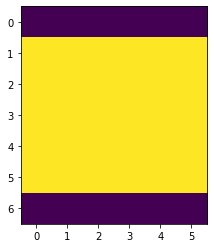

In [22]:
%matplotlib inline
plt.imshow(mask2[18])

In [25]:
print(mask2.shape, met2.shape)
# checking array shapes are the same

(20, 5, 6) (20, 5, 6)


In [26]:
MA=mask2.flatten()
ME=met2.flatten()

In [29]:
both=0
neither=0
mask_only=0
metric_only=0
for i, ma in enumerate(MA):
    if ma==1 and ME[i]>0:
        both=both+1
    elif ma==1 and ME[i]==0.0:
        mask_only=mask_only+1
    elif ME[i]>0 and ma==0:
        metric_only = metric_only+1
    elif ma==0 and ME[i]==0.0:
        neither=neither+1
    else:
        print("unexpected condition!")
        
print("both = " + str(both))
print("neither = " + str(neither))
print("mask only = " + str(mask_only))
print("metric only =" +str(metric_only))

print("Alignment accuracy = {0} %".format(((both+neither)/(both+neither+mask_only+metric_only))*100))

both = 361
neither = 143
mask only = 23
metric only =73
Alignment accuracy = 84.0 %


In [33]:
#pull out and write the registered datasets
mask_reg=CT_registration(mask)
porosity_reg=CT_registration(porosity)

print(mask_reg.shape, porosity_reg.shape)

with h5py.File("Chamfer_registered_demo_2mm.h5", 'w') as f:
    f.create_dataset("mask", shape=mask_reg.shape, data=mask_reg, dtype='uint8')
    f.create_dataset("pores", shape=porosity_reg.shape, data=porosity_reg, dtype='float64')
    with h5py.File(metric_file, 'r') as h:
        for key in h.keys():
            met=np.array(h[key], dtype='float64')
            met_reg=MET_registration(met)
            
            f.create_dataset(key, shape=met_reg.shape, data=met_reg, dtype='float64')

print(met_reg.shape)

(20, 5, 6) (20, 5, 6)
(20, 5, 6)


In [477]:
# look at correlation
binned_reg={}

with h5py.File("registered_data.h5", 'r') as f:
    for key in f.keys():
        binned_reg[key]=np.array(f[key], dtype='float64')

In [478]:
%matplotlib notebook
import ipywidgets as widgets
from ipywidgets import interact
def update_plot(binned_reg, attr, ax):
    sc.set_offsets(np.c_[binned_reg['pores'].flatten(), binned_reg[attr].flatten()])
    ax.set_ylim([0, max(binned_reg[attr].flatten())+10])
    
x=binned_reg['pores'].flatten()   
y=binned_reg['mse-Spatter number'].flatten()
fig, ax = plt.subplots()
sc = ax.scatter(x,y, 0.5)
ax.set_xscale('log')
ax.set_xlim([0.0003, 3])

@interact(attr = widgets.Dropdown(options=binned_reg.keys()))
def _(attr):
    update_plot(binned_reg, attr, ax)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(Dropdown(description='attr', options=('mask', 'max-Plume area (um2)', 'max-Plume major a…